In [9]:
import pandas as pd

import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_turned_off=False, drop_na=True)

# Übersicht

In diesem Notebook werden zwei Konzepte betrachtet und ausgearbeitet, die für alle folgenden Notebooks relevant sind: Cross validation splitting sowie Modell evaluation.

Zuvor wird zum besseren Verständnis exemplarisch ein überblick über die Daten gegeben. Dafür wird in der folgenden Visualisierung der Zeitraum vom 10-01-2023bis zum 20-01-2023 betrachtet. Dargestellt wird der Ladezustand des Pufferspeichers in Abhängigkeit von der Zeit. Daran ist direkt zu erkennen, dass bei positiver Steigung der Puffer Energie aufnimmt und daher der Ofen brennt. Bei negativer Steigung gibt der Puffer Energie ab.

Zusätzlich sind die tatsächlichen spätesten Nachfüllzeitpunkte als vertikale Linien eingezeichnet. Diese Zeitpunkte sollen vorhergesagt werden (bzw. die Dauer, bis der Zeitpunkt erreicht wird). Der Puffer ladegrad ist jeweils in der Farbe dargestellt, in der auch der zugehörige Nachfüllzeitpunkt eingezeichnet ist. Hier wird noch einmal deutlich, dass dies nicht immer der nächste Nachfüllzeitpunkt ist, da der Ofen bereits mit neuem Holz befüllt sein kann und der Ofen automatisch wieder zündet, wenn der Puffer leer ist (= 15 % hat).

Lücken in den Daten entstehen, wenn der tatsächliche späteste Nachfüllzeitpunkt nicht ermittelt werden kann. Dies ist der Fall, wenn der Ofen vorzeitig manuell gezündet wird und somit der Puffer nie 15 % erreicht. 

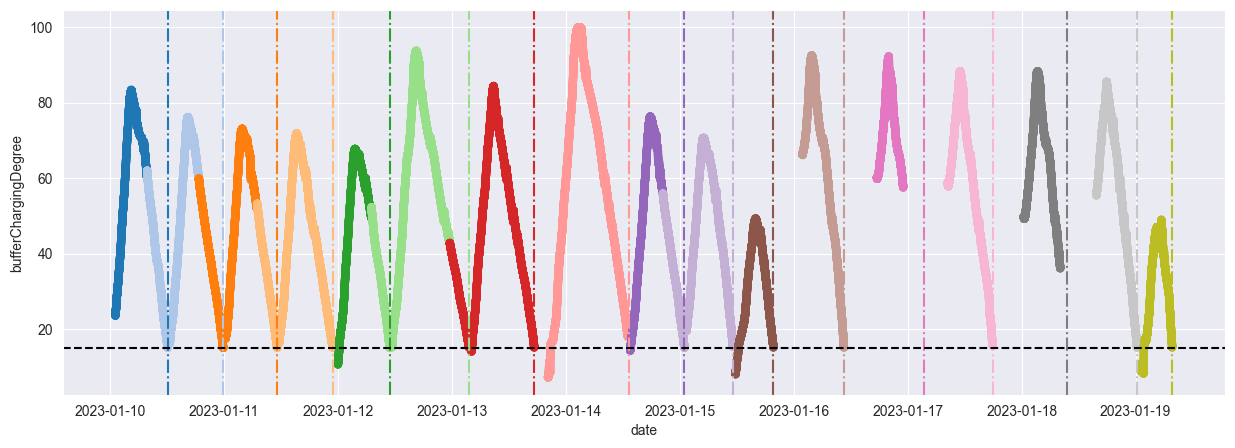

In [10]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

start_date = datetime(2023, 1, 10)
end_date = datetime(2023, 1, 20)

display_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

color_palette_name = 'tab20'

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(data=display_df, x="date", y="bufferChargingDegree", ax=ax, label="bufferChargingDegree", linewidth=0, hue='refuellingDateActual', palette=color_palette_name)

# find all unique refuelling dates
refuelling_dates = display_df['refuellingDateActual'].unique()

# remove null
refuelling_dates = refuelling_dates[~pd.isnull(refuelling_dates)]

for index, refuelling_date in enumerate(refuelling_dates):
    # get color from palette
    color_palette = sns.color_palette(color_palette_name)
    color = color_palette[index % len(color_palette)]
    ax.axvline(refuelling_date, linestyle='-.', color=color)
    
# add a horizontal line at y = 15
ax.axhline(15, color='black', linestyle='--')

# hide the legend
ax.legend().remove()


## Cross validation splitting

Um Modelle bewerten zu können, müssen die Daten in Trainings- und Testdaten aufgeteilt werden. So kann man die Evaluation des Modells auf neuen Daten durchführen. Im einfachsten Fall werden die Daten einmal geteilt und ein Teil für das Training und ein Teil zum Testen verwendet. Ein verbesserter Ansatz stellt Cross Validation (CV) dar, bei dem die Daten mehrfach geteilt werden. In dieser Arbeit wird daher CV verwendet.

In jedem Fall stellt sich die Frage, wie die Daten aufgeteilt werden. Bei einfachen Datensätzen, bei denen es keine Abhängigkeiten zwischen den einzelnen Datenpunkten gibt, kann man den Datensatz einfach shuffeln, in `n` gleich große Teile schneiden und anschließend jeweils einen zum Testen verwenden.
Dieser Ansatz ist bei diesem Datensatz ungeeignet, da zeitlich nah beieinanderliegende Datenpunkt in der Regel fast identisch sind, sodass die Trainingsdaten in diesem Fall gar keine neuen Daten für das Modell wären.

Dazu kommt, dass bei Zeitreihen darauf geachtet werden muss, dass zukünftige Daten nicht zum Trainieren verwendet werden. Das bedeutet, dass alle Datenpunkt aus dem Testset aktueller bzw. neuer sein müssen als alle Datenpunkte aus dem Trainingsset. Dies ist wichtig, da das Modell sonst in der Lage wäre, in die Zukunft zu schauen und somit die Performance auf neuen Daten nicht korrekt bewertet werden kann. Wenn dies doch passiert, wird von einem Leaking von Daten gesprochen und muss unbedingt vermieden werden.

Wenn man nicht CV verwendet, kann man einfach die letzten bzw. neusten x-Prozent zum Testen und den Rest zum Trainieren verwendet. Dadurch wird verhindert, dass neuer Daten in die Trainingsdaten leaken. Für CV ist in Python bereit `TimeSeriesSplit` implementiert. Dieser Splitter stellt sicher, dass das Leaken von Trainingsdaten unterbunden wird.

Im Fall von diesem Datensatz könnte man überlegen, wie problematisch Leaking ist. Die einzelnen Brennvorgänge laufen größtenteils unabhängig, sodass aus Datenpunkten von zukünftigen Brennvorgängen kaum Rückschlüsse auf die Vergangenheit gezogen werden können. Allerdings beeinflussen zum Beispiel Rußablagerungen auch zukünftige Brennvorgänge, sodass es doch zu Leaking kommen kann. Die Signifikanz dieses Einflusses ist jedoch unbekannt. Daher wird in dieser Arbeit `TimeSeriesSplit` verwendet, um Leaking zu verhindern.

In [11]:
df['date'].max()

Timestamp('2023-08-30 23:24:10')

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


def extract_measures_from_split(train_index, test_index):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    train_min_date = train_df['date'].min()
    train_max_date = train_df['date'].max()
    test_min_date = test_df['date'].min()
    test_max_date = test_df['date'].max()
    
    train_duration = train_max_date - train_min_date
    test_duration = test_max_date - test_min_date
    
    return {
        'train_min_date': train_min_date,
        'train_max_date': train_max_date,
        'test_min_date': test_min_date,
        'test_max_date': test_max_date,
        'train_duration': train_duration,
        'test_duration': test_duration
    }

split_df = pd.DataFrame([extract_measures_from_split(train_index, test_index) for train_index, test_index in tscv.split(df)])

split_df

,train_min_date,train_max_date,test_min_date,test_max_date,train_duration,test_duration
0,2019-11-13 10:32:10,2021-03-08 19:53:10,2021-03-08 19:53:20,2022-05-15 02:00:10,481 days 09:21:00,432 days 06:06:50
1,2019-11-13 10:32:10,2022-05-15 02:00:10,2022-05-15 02:00:20,2023-08-30 23:24:10,913 days 15:28:00,472 days 21:23:50


## Modell evaluation

Um die Performance von den Modellen zu bewerten und mit der Vorhersage des Ofens zu vergleichen, muss eine geeignete Kenngröße gefunden werden. Um einen Einblick in die Daten zu erhalten, wird zunächst die Verteilung der Zielvariable `refuellingTimePointActual` betrachtet:

<Axes: xlabel='month', ylabel='refuellingTimePointActual'>

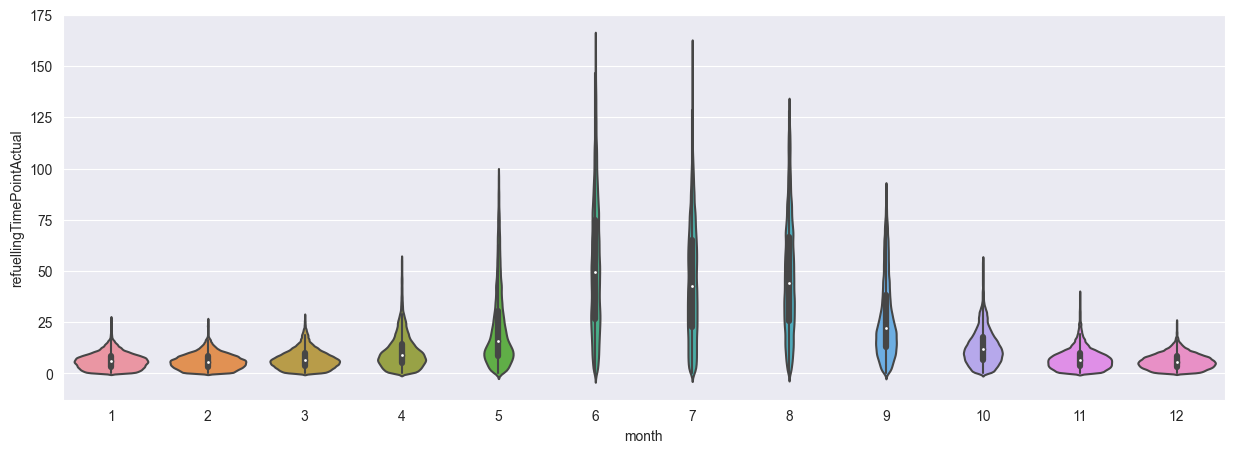

In [13]:
df['month'] = df['date'].dt.month

fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=df, x="month", y="refuellingTimePointActual", ax=ax)


Auffällig ist die starke Varianz der Zielvariable. In den Wintermonaten werden 20h selten überschritten, meistens sind es deutlich weniger als 10h. Im Sommer hingegen sind auch Werte größer als 100h = 4 Tage möglich.

Am Ende ist ein Modell gewünscht, dass den Nachfüllzeitpunkt berechnet. Wenige Stunden vor dem Nachfüllzustand sollte die Vorhersage daher eine deutlich höhere absolute Genauigkeit haben, als Tage vor dem Nachfüllzustand. Wenn der Nachfüllzustand zum Beispiel nur noch zwei Stunden entfernt ist, ist eine Abweichung von 1h deutlich schlimmer, als wenn der Nachfüllzustand noch 2 Tage entfernt ist.

Würde man nun den MSE verwenden, wäre eine Abweichung von 1h in beiden Fällen gleich schlimm. Daher wird in dieser Arbeit der MAPE (Mean Absolute Percentage Error) verwendet. Dieser ist definiert als:

$$MAPE = \frac{1}{n} \sum_{i=1}^{n-1} \frac{\left|y_i - \hat{y_i}\right|}{max(\epsilon, \left|y_i\right|)}$$

wobei $\epsilon$ als kleiner Wert verwendet wird, um Division durch 0 zu verhindern.

[Mean absolute percentage error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error)

In [14]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

y_actual = df['refuellingTimePointActual']
y_pred = df['refuellingTimePoint']

mape = mean_absolute_percentage_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
print(f'MAPE:  {mape:.2f}')
print(f'MSE:   {mse:.2f}')
print(f'RMSE:  {np.sqrt(mse):.2f}')


MAPE:  0.69
MSE:   143.28
RMSE:  11.97


In [15]:

# get all data where the refuelling is at least 10 minutes
df2 = df[df['refuellingTimePointActual'] >= 10/60]


y_actual2 = df2['refuellingTimePointActual']
y_pred2 = df2['refuellingTimePoint']

mape = mean_absolute_percentage_error(y_actual2, y_pred2)
print(f'MAPE:  {mape:.2f}')


MAPE:  0.50


Um den Unterschied zwischen MSE und MAPE zu verdeutlichen, kann man sich die beiden Metriken für die Monate einzeln anschauen.

Betrachtet man nur den MSE, bzw RMSE, dann ist die Prognose in den Wintermonaten mit einer durchschnittlichen Abweichung von 4h deutlich besser als die Prognose in den Sommermonaten mit 17h. Tatsächlich ist es jedoch genau andersherum, da eine Abweichung von 4h im Winter sehr viel schlimmer ist, als eine Abweichung von 17h im Sommer. Der MAPE berücksichtigt dies hingegen und ist daher die bessere Metrik für diesen Datensatz und wird im Folgenden verwendet.

In [16]:
# get months
months = df['date'].dt.month.unique()

# sort months
months = np.sort(months)

def calculate_measures_for_month(month):
    y_prediction_month = df[df['date'].dt.month == month]['refuellingTimePoint']
    y_actual_month = df[df['date'].dt.month == month]['refuellingTimePointActual']
    
    # calculate mean squared error
    mse_month = mean_squared_error(y_actual_month, y_prediction_month)
    mape_month = mean_absolute_percentage_error(y_actual_month, y_prediction_month)
    
    return {
        'month': month,
        'mse': mse_month,
        'rmse': np.sqrt(mse_month),
        'mape': mape_month
    }

month_df = pd.DataFrame([calculate_measures_for_month(month) for month in months])
month_df

,month,mse,rmse,mape
0,1,18.751719,4.330326,1.014429
1,2,12.529085,3.539645,1.041176
2,3,16.225042,4.028032,0.857634
3,4,29.237607,5.407181,0.701970
4,5,141.069671,11.877275,0.513328
5,6,360.922192,18.997952,0.369160
6,7,298.235314,17.269491,0.395058
7,8,253.557656,15.923494,0.316632
8,9,404.792460,20.119455,0.676763
9,10,52.132510,7.220285,0.645895
